In [6]:
# Real life data

import logging
import threading
import json
import itertools
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import seaborn as seabornInstance
from sqlalchemy import Column, Integer, String, Float, DateTime, Boolean, func
from iotfunctions import base
from iotfunctions import bif
from iotfunctions import entity
from iotfunctions import metadata
from iotfunctions.metadata import EntityType
from iotfunctions.db import Database
from iotfunctions.enginelog import EngineLogging
from iotfunctions import estimator
from iotfunctions.ui import (UISingle, UIMultiItem, UIFunctionOutSingle,
                 UISingleItem, UIFunctionOutMulti, UIMulti, UIExpression,
                 UIText, UIStatusFlag, UIParameters)
from mmfunctions.anomaly import (SaliencybasedGeneralizedAnomalyScore, SpectralAnomalyScore,
                 FFTbasedGeneralizedAnomalyScore, KMeansAnomalyScore, Interpolator)
import datetime as dt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import scipy as sp
import scipy.fftpack
import skimage as ski  
from skimage import util as skiutil # for nifty windowing
import pyod as pyod
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from pyod.models.knn import KNN
from pyod.models.iforest import IForest
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

EngineLogging.configure_console_logging(logging.INFO)

2020-07-27T20:58:50.173 DEBUG matplotlib.pyplot.switch_backend Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [7]:
# setting to make life easier
Temperature='Temperature'
kmeans='TemperatureKmeansScore'
fft='TemperatureFFTScore'
fftp='TemperatureFFTPScore'
spectral='TemperatureSpectralScore'
sal='SaliencyAnomalyScore'
gen='TemperatureGeneralizedScore'
kmeansA='kmeansAnomaly'
kmeansB='kmeansAnomalyB'
spectralA='spectralAnomaly'
fftA='fftAnomaly'
fftpA='fftpAnomaly'
salA='salAnomaly'
genA='genAnomaly'

kmeans_break=1.9
spectral_break = 2.8
fft_break = 100
sal_break = 100
gen_break = 30000



#### What will be shown

General approach is straightforward
* read raw data in
* transform it so that it is compatible to the Monitoring pipeline
* add yet another anomaly detector based on computer vision technology. The point here is to show how to run pipeline anomaly functions 'locally', an important concept for automated testing.
* simplify the dataframe - we have only one entity, no need for an entity index
* render input data and anomaly scores properly scaled

<br>

We start with Microsoft's anomaly test data found here
https://github.com/microsoft/anomalydetector/blob/master/samples/sample.csv

and then proceed to applying anomaly detection to real life pump data


<br>


#### Current inventory of anomaly detectors by type

This is the list of functions to apply


| Detector | ML Type | Type         | How does it work |
| ------- | ------------ | ------- | ---------------- |
| KMeans | Unsupervised | Proximity | Clusters data points in centroid buckets, small buckets are outliers, score is distance to closest other bucket |
| Generalized | Unsupervised | Linear Model | Covariance matrix over data point vectors serves to measure multi-dimensional deviation |
| FFT | Unsupervised | Linear Model | Run FFT before applying Generalized |
| Spectral | Unsupervised | Linear Model | Compute signal energy to reduce dimensions |
| Saliency | Unsupervised | Linear Model | Apply saliency transform (from computer vision |
| SimpleAnomaly | **Supervised** | Ensemble | Run Gradient boosting on training data, anomaly if prediction deviates from actual data |
| --- | **Supervised** | LSTM | Train a stacked LSTM, anomaly if prediction deviates from actual data |



In [8]:
# Run on the good pump first 
# Get stuff in
df_i = pd.read_csv('./samples/AzureAnomalysample.csv', index_col=False, parse_dates=['timestamp'])

df_i['entity']='MyRoom'
df_i['Temperature']=df_i['value'] + 20
df_i = df_i.drop(columns=['value'])

# and sort it by timestamp
df_i = df_i.sort_values(by='timestamp')
df_i = df_i.set_index(['entity','timestamp']).dropna()

df_i.head(2)

Temperature
entity timestamp                       
MyRoom 2017-10-09 20:32:00         23.0
       2017-10-09 20:33:00         23.0

In [9]:
# Now run the anomaly functions as if they were executed in a pipeline

#interi = Interpolator(Temperature, 12, 23.0, 'TemperatureInter')  
interi = Interpolator(Temperature, 12, 22.9375, 'TemperatureInter')   # drop 22.9375
et = interi._build_entity_type(columns = [Column(Temperature,Float())])
interi._entity_type = et
df_i = interi.execute(df=df_i)


df_i.head(30)

2020-07-27T20:58:52.796 WARNING iotfunctions.metadata.__init__ No _db_schema specified in **kwargs. Usingdefault database schema.
2020-07-27T20:58:52.797 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.


Temperature  TemperatureInter
entity timestamp                                         
MyRoom 2017-10-09 20:32:00      23.0000           23.0000
       2017-10-09 20:33:00      23.0000           23.0000
       2017-10-09 20:34:00      23.0000           23.0000
       2017-10-09 20:35:00      23.0000           23.0000
       2017-10-09 20:36:00      23.0000           23.0000
       2017-10-09 20:37:00      22.9375           23.0000
       2017-10-09 20:38:00      23.0000           23.0000
       2017-10-09 20:39:00      22.9375           23.0000
       2017-10-09 20:40:00      23.0000           23.0000
       2017-10-09 20:41:00      22.9375           23.0000
       2017-10-09 20:42:00      22.9375           23.0625
       2017-10-09 20:43:00      23.0625           23.0625
       2017-10-09 20:44:00      22.8750           22.8750
       2017-10-09 20:45:00      22.8750           22.8750
       2017-10-09 20:46:00      22.9375           22.8750
       2017-10-09 20:47:00      23.0000           23.0000
       2017-10-09 20:48:00      22.9375           23.0000
       2017-10-09 20:49:00      22.8125           22.8125
       2017-10-09 20:50:00      22.9375           22.8125
       2017-10-09 20:51:00      22.8125           22.8125
       2017-10-09 20:52:00      23.0000           23.0000
       2017-10-09 20:53:00      22.8750           22.8750
       2017-10-09 20:54:00      22.9375           22.8750
       2017-10-09 20:55:00      22.8750           22.8750
       2017-10-09 20:56:00      22.8125           22.8125
       2017-10-09 20:57:00      22.8125           22.8125
       2017-10-09 20:58:00      22.8750           22.8750
       2017-10-09 20:59:00      22.9375           22.8750
       2017-10-09 21:00:00      22.9375           22.8750
       2017-10-09 21:01:00      22.8750           22.8750

In [4]:
# Now run the anomaly functions as if they were executed in a pipeline

spsi = SpectralAnomalyScore(Temperature, 12, spectral)
et = spsi._build_entity_type(columns = [Column(Temperature,Float())])
spsi._entity_type = et
df_i = spsi.execute(df=df_i)

sali = SaliencybasedGeneralizedAnomalyScore(Temperature, 12, sal)
et = sali._build_entity_type(columns = [Column(Temperature,Float())])
sali._entity_type = et
df_i = sali.execute(df=df_i)

ffti = FFTbasedGeneralizedAnomalyScore(Temperature, 12, fft)
et = ffti._build_entity_type(columns = [Column(Temperature,Float())])
ffti._entity_type = et
df_i = ffti.execute(df=df_i)

kmi = KMeansAnomalyScore(Temperature, 12, kmeans)
et = kmi._build_entity_type(columns = [Column(Temperature,Float())])
kmi._entity_type = et
df_i = kmi.execute(df=df_i)

df_i.head(30)

2020-07-27T20:53:57.067 DEBUG mmfunctions.anomaly.__init__ Temperature
2020-07-27T20:53:57.068 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 2.0.3
2020-07-27T20:53:57.069 DEBUG iotfunctions.util.__init__ Starting trace
2020-07-27T20:53:57.070 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_SpectralAnomalyScore_20200727185357
2020-07-27T20:53:57.070 DEBUG iotfunctions.util.__init__ auto_save None
2020-07-27T20:53:57.071 WARNING iotfunctions.metadata.__init__ No _db_schema specified in **kwargs. Usingdefault database schema.
2020-07-27T20:53:57.071 DEBUG iotfunctions.util.categorize_args categorizing arguments
2020-07-27T20:53:57.072 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-07-27T20:53:57.073 DEBUG iotfunctions.metadata.__init__ Initialized entity type 
LocalEntityType:None
Functions:
Granularities:
No

2020-07-27T20:53:59.729 DEBUG numba.core.byteflow.run pending: deque([State(pc_initial=0 nstack_initial=0)])
2020-07-27T20:53:59.730 DEBUG numba.core.byteflow.run stack: []
2020-07-27T20:53:59.731 DEBUG numba.core.byteflow.dispatch dispatch pc=0, inst=NOP(arg=None, lineno=70)
2020-07-27T20:53:59.732 DEBUG numba.core.byteflow.dispatch stack []
2020-07-27T20:53:59.732 DEBUG numba.core.byteflow.dispatch dispatch pc=2, inst=LOAD_GLOBAL(arg=0, lineno=70)
2020-07-27T20:53:59.733 DEBUG numba.core.byteflow.dispatch stack []
2020-07-27T20:53:59.733 DEBUG numba.core.byteflow.dispatch dispatch pc=4, inst=LOAD_METHOD(arg=1, lineno=70)
2020-07-27T20:53:59.734 DEBUG numba.core.byteflow.dispatch stack ['$2load_global.0']
2020-07-27T20:53:59.734 DEBUG numba.core.byteflow.dispatch dispatch pc=6, inst=LOAD_FAST(arg=1, lineno=70)
2020-07-27T20:53:59.735 DEBUG numba.core.byteflow.dispatch stack ['$4load_method.1']
2020-07-27T20:53:59.735 DEBUG numba.core.byteflow.dispatch dispatch pc=8, inst=LOAD_FAST(arg

2020-07-27T20:53:59.758 DEBUG numba.core.ssa.reconstruct_ssa -----------------------------------BEFORE SSA-----------------------------------
2020-07-27T20:53:59.759 DEBUG numba.core.ssa.reconstruct_ssa label 0:
    X = arg(0, name=X)                       ['X']
    Y = arg(1, name=Y)                       ['Y']
    $2load_global.0 = global(np: <module 'numpy' from '/home/markus/.local/lib/python3.8/site-packages/numpy/__init__.py'>) ['$2load_global.0']
    $4load_method.1 = getattr(value=$2load_global.0, attr=square) ['$2load_global.0', '$4load_method.1']
    $10binary_subtract.4 = Y - X             ['$10binary_subtract.4', 'X', 'Y']
    $12call_method.5 = call $4load_method.1($10binary_subtract.4, func=$4load_method.1, args=[Var($10binary_subtract.4, stat_models.py:70)], kws=(), vararg=None) ['$10binary_subtract.4', '$12call_method.5', '$4load_method.1']
    euclidean_sq = $12call_method.5          ['$12call_method.5', 'euclidean_sq']
    $16load_global.6 = global(np: <module 'numpy'

2020-07-27T20:53:59.768 DEBUG numba.core.ssa.reconstruct_ssa ================================================================================
2020-07-27T20:53:59.780 DEBUG numba.core.byteflow.__init__ bytecode dump:
>          0	NOP(arg=None, lineno=1)
           2	LOAD_GLOBAL(arg=0, lineno=1)
           4	LOAD_FAST(arg=1, lineno=70)
           6	LOAD_FAST(arg=0, lineno=70)
           8	BINARY_SUBTRACT(arg=None, lineno=1)
          10	CALL_FUNCTION(arg=1, lineno=1)
          12	RETURN_VALUE(arg=None, lineno=1)
2020-07-27T20:53:59.780 DEBUG numba.core.byteflow.run pending: deque([State(pc_initial=0 nstack_initial=0)])
2020-07-27T20:53:59.780 DEBUG numba.core.byteflow.run stack: []
2020-07-27T20:53:59.781 DEBUG numba.core.byteflow.dispatch dispatch pc=0, inst=NOP(arg=None, lineno=1)
2020-07-27T20:53:59.781 DEBUG numba.core.byteflow.dispatch stack []
2020-07-27T20:53:59.781 DEBUG numba.core.byteflow.dispatch dispatch pc=2, inst=LOAD_GLOBAL(arg=0, lineno=1)
2020-07-27T20:53:59.782 DEBUG nu

2020-07-27T20:53:59.821 DEBUG numba.core.byteflow.__init__ bytecode dump:
>          0	NOP(arg=None, lineno=201)
           2	LOAD_FAST(arg=0, lineno=201)
           4	LOAD_FAST(arg=2, lineno=201)
           6	COMPARE_OP(arg=4, lineno=201)
           8	POP_JUMP_IF_FALSE(arg=14, lineno=201)
          10	LOAD_CONST(arg=1, lineno=204)
          12	RETURN_VALUE(arg=None, lineno=204)
>         14	LOAD_CONST(arg=1, lineno=206)
          16	STORE_FAST(arg=4, lineno=206)
          18	LOAD_FAST(arg=2, lineno=207)
          20	LOAD_FAST(arg=0, lineno=207)
          22	BINARY_SUBTRACT(arg=None, lineno=207)
          24	STORE_FAST(arg=5, lineno=207)
>         26	LOAD_FAST(arg=4, lineno=208)
          28	LOAD_FAST(arg=0, lineno=208)
          30	COMPARE_OP(arg=0, lineno=208)
          32	POP_JUMP_IF_FALSE(arg=120, lineno=208)
          34	LOAD_FAST(arg=1, lineno=209)
          36	LOAD_FAST(arg=4, lineno=209)
          38	BINARY_SUBSCR(arg=None, lineno=209)
          40	STORE_FAST(arg=6, lineno=209)

2020-07-27T20:53:59.845 DEBUG numba.core.byteflow.dispatch stack ['$38binary_subscr.2']
2020-07-27T20:53:59.846 DEBUG numba.core.byteflow.dispatch dispatch pc=42, inst=LOAD_FAST(arg=3, lineno=210)
2020-07-27T20:53:59.846 DEBUG numba.core.byteflow.dispatch stack []
2020-07-27T20:53:59.847 DEBUG numba.core.byteflow.dispatch dispatch pc=44, inst=LOAD_FAST(arg=5, lineno=210)
2020-07-27T20:53:59.847 DEBUG numba.core.byteflow.dispatch stack ['$dest_shape42.3']
2020-07-27T20:53:59.848 DEBUG numba.core.byteflow.dispatch dispatch pc=46, inst=BINARY_SUBSCR(arg=None, lineno=210)
2020-07-27T20:53:59.848 DEBUG numba.core.byteflow.dispatch stack ['$dest_shape42.3', '$dest_index44.4']
2020-07-27T20:53:59.849 DEBUG numba.core.byteflow.dispatch dispatch pc=48, inst=STORE_FAST(arg=7, lineno=210)
2020-07-27T20:53:59.849 DEBUG numba.core.byteflow.dispatch stack ['$46binary_subscr.5']
2020-07-27T20:53:59.850 DEBUG numba.core.byteflow.dispatch dispatch pc=50, inst=LOAD_FAST(arg=7, lineno=213)
2020-07-27T20:

2020-07-27T20:53:59.883 DEBUG numba.core.byteflow.dispatch stack []
2020-07-27T20:53:59.883 DEBUG numba.core.byteflow.run end state. edges=[Edge(pc=26, stack=(), blockstack=(), npush=0)]
2020-07-27T20:53:59.884 DEBUG numba.core.byteflow.run pending: deque([State(pc_initial=94 nstack_initial=0), State(pc_initial=102 nstack_initial=0), State(pc_initial=74 nstack_initial=0), State(pc_initial=102 nstack_initial=0), State(pc_initial=26 nstack_initial=0)])
2020-07-27T20:53:59.884 DEBUG numba.core.byteflow.run stack: []
2020-07-27T20:53:59.884 DEBUG numba.core.byteflow.dispatch dispatch pc=94, inst=LOAD_FAST(arg=6, lineno=221)
2020-07-27T20:53:59.885 DEBUG numba.core.byteflow.dispatch stack []
2020-07-27T20:53:59.885 DEBUG numba.core.byteflow.dispatch dispatch pc=96, inst=LOAD_FAST(arg=3, lineno=221)
2020-07-27T20:53:59.885 DEBUG numba.core.byteflow.dispatch stack ['$src_dim_size94.0']
2020-07-27T20:53:59.886 DEBUG numba.core.byteflow.dispatch dispatch pc=98, inst=LOAD_FAST(arg=5, lineno=221)

2020-07-27T20:53:59.899 DEBUG numba.core.byteflow.run block_infos State(pc_initial=74 nstack_initial=0):
AdaptBlockInfo(insts=((74, {'res': '$dest_index74.0'}), (76, {'res': '$const76.1'}), (78, {'lhs': '$dest_index74.0', 'rhs': '$const76.1', 'res': '$78binary_add.2'}), (80, {'value': '$78binary_add.2', 'res': '$80unary_negative.3'}), (82, {'retval': '$80unary_negative.3', 'castval': '$82return_value.4'})), outgoing_phis={}, blockstack=(), active_try_block=None, outgoing_edgepushed={})
2020-07-27T20:53:59.899 DEBUG numba.core.byteflow.run block_infos State(pc_initial=86 nstack_initial=0):
AdaptBlockInfo(insts=((86, {'res': '$src_dim_size86.0'}), (88, {'res': '$const88.1'}), (90, {'lhs': '$src_dim_size86.0', 'rhs': '$const88.1', 'res': '$90compare_op.2'}), (92, {'pred': '$90compare_op.2'})), outgoing_phis={}, blockstack=(), active_try_block=None, outgoing_edgepushed={94: (), 102: ()})
2020-07-27T20:53:59.900 DEBUG numba.core.byteflow.run block_infos State(pc_initial=94 nstack_initial=0)

2020-07-27T20:53:59.915 DEBUG numba.core.ssa.reconstruct_ssa ================================================================================
2020-07-27T20:53:59.915 DEBUG numba.core.ssa._run_block_analysis ==== SSA block analysis pass on 0
2020-07-27T20:53:59.916 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._GatherDefsHandler object at 0x7fa307c23e20>
2020-07-27T20:53:59.916 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: src_ndim = arg(0, name=src_ndim)
2020-07-27T20:53:59.917 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: src_shape = arg(1, name=src_shape)
2020-07-27T20:53:59.917 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: dest_ndim = arg(2, name=dest_ndim)
2020-07-27T20:53:59.918 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: dest_shape = arg(3, name=dest_shape)
2020-07-27T20:53:59.919 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $6compare_op.2 = src_ndim > dest_ndim
2020-07-27T20:53:59.919 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: bra

2020-07-27T20:53:59.944 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: return $122return_value.1
2020-07-27T20:53:59.945 DEBUG numba.core.ssa._find_defs_violators defs defaultdict(<class 'list'>,
            {'$106inplace_add.2': [<numba.core.ir.Assign object at 0x7fa307bb5610>],
             '$114inplace_add.5': [<numba.core.ir.Assign object at 0x7fa307bb5af0>],
             '$122return_value.1': [<numba.core.ir.Assign object at 0x7fa307bb5f10>],
             '$12return_value.1': [<numba.core.ir.Assign object at 0x7fa307c27cd0>],
             '$22binary_subtract.3': [<numba.core.ir.Assign object at 0x7fa307bad2b0>],
             '$30compare_op.2': [<numba.core.ir.Assign object at 0x7fa307bad7f0>],
             '$38binary_subscr.2': [<numba.core.ir.Assign object at 0x7fa307badc70>],
             '$46binary_subscr.5': [<numba.core.ir.Assign object at 0x7fa307bb1190>],
             '$54compare_op.8': [<numba.core.ir.Assign object at 0x7fa307bb16d0>],
             '$62compare_op.2': [<

2020-07-27T20:53:59.986 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const76.1 = const(int, 1)
2020-07-27T20:53:59.986 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $78binary_add.2 = dest_index + $const76.1
2020-07-27T20:53:59.986 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $80unary_negative.3 = unary(fn=<built-in function neg>, value=$78binary_add.2)
2020-07-27T20:53:59.987 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $82return_value.4 = cast(value=$80unary_negative.3)
2020-07-27T20:53:59.987 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: return $82return_value.4
2020-07-27T20:53:59.987 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 86
2020-07-27T20:53:59.988 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FreshVarHandler object at 0x7fa307c23e20>
2020-07-27T20:53:59.988 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const88.1 = const(int, 1)
2020-07-27T20:53:59.988 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: 

2020-07-27T20:54:00.015 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $54compare_op.8 = dest_dim_size != $const52.7
2020-07-27T20:54:00.015 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: branch $54compare_op.8, 58, 86
2020-07-27T20:54:00.016 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 58
2020-07-27T20:54:00.016 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FixSSAVars object at 0x7fa307c335e0>
2020-07-27T20:54:00.016 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $62compare_op.2 = src_dim_size != dest_dim_size
2020-07-27T20:54:00.017 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: branch $62compare_op.2, 66, 102
2020-07-27T20:54:00.017 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 66
2020-07-27T20:54:00.017 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FixSSAVars object at 0x7fa307c335e0>
2020-07-27T20:54:00.018 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const68.1 = const(int,

2020-07-27T20:54:00.039 DEBUG numba.core.ssa._find_def_from_top find_def_from_top label 58
2020-07-27T20:54:00.039 DEBUG numba.core.ssa._find_def_from_top idom 34 from label 58
2020-07-27T20:54:00.040 DEBUG numba.core.ssa._find_def_from_bottom find_def_from_bottom label 34
2020-07-27T20:54:00.040 DEBUG numba.core.ssa._find_def_from_top find_def_from_top label 34
2020-07-27T20:54:00.040 DEBUG numba.core.ssa._find_def_from_top idom 26 from label 34
2020-07-27T20:54:00.041 DEBUG numba.core.ssa._find_def_from_bottom find_def_from_bottom label 26
2020-07-27T20:54:00.041 DEBUG numba.core.ssa._find_def_from_top incoming_def dest_index.2 = phi(incoming_values=[Var(dest_index.1, npyimpl.py:223), Var(dest_index, npyimpl.py:207)], incoming_blocks=[102, 14])
2020-07-27T20:54:00.041 DEBUG numba.core.ssa._find_def_from_bottom find_def_from_bottom label 66
2020-07-27T20:54:00.041 DEBUG numba.core.ssa._find_def_from_top find_def_from_top label 66
2020-07-27T20:54:00.042 DEBUG numba.core.ssa._find_def_

2020-07-27T20:54:00.064 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: branch $54compare_op.8, 58, 86
2020-07-27T20:54:00.064 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 58
2020-07-27T20:54:00.065 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FreshVarHandler object at 0x7fa307c8f3d0>
2020-07-27T20:54:00.088 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $62compare_op.2 = src_dim_size != dest_dim_size
2020-07-27T20:54:00.088 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: branch $62compare_op.2, 66, 102
2020-07-27T20:54:00.089 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 66
2020-07-27T20:54:00.089 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FreshVarHandler object at 0x7fa307c8f3d0>
2020-07-27T20:54:00.090 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const68.1 = const(int, 1)
2020-07-27T20:54:00.090 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $70compare_op.2 = src_dim_size !

2020-07-27T20:54:00.114 DEBUG numba.core.ssa._find_def_from_bottom find_def_from_bottom label 102
2020-07-27T20:54:00.115 DEBUG numba.core.ssa._find_def_from_top incoming_def src_index.1 = $106inplace_add.2
2020-07-27T20:54:00.115 DEBUG numba.core.ssa._find_def_from_bottom find_def_from_bottom label 14
2020-07-27T20:54:00.115 DEBUG numba.core.ssa._find_def_from_top incoming_def src_index = $const14.0
2020-07-27T20:54:00.116 DEBUG numba.core.ssa._run_ssa_block_pass replaced with: $30compare_op.2 = src_index.2 < src_ndim
2020-07-27T20:54:00.116 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: branch $30compare_op.2, 34, 120
2020-07-27T20:54:00.116 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 34
2020-07-27T20:54:00.117 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FixSSAVars object at 0x7fa307c99c40>
2020-07-27T20:54:00.117 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $38binary_subscr.2 = getitem(value=src_shape, index=src_index)
2020-07

2020-07-27T20:54:00.146 DEBUG numba.core.ssa.reconstruct_ssa label 0:
    src_ndim = arg(0, name=src_ndim)         ['src_ndim']
    src_shape = arg(1, name=src_shape)       ['src_shape']
    dest_ndim = arg(2, name=dest_ndim)       ['dest_ndim']
    dest_shape = arg(3, name=dest_shape)     ['dest_shape']
    $6compare_op.2 = src_ndim > dest_ndim    ['$6compare_op.2', 'dest_ndim', 'src_ndim']
    branch $6compare_op.2, 10, 14            ['$6compare_op.2']
label 10:
    $const10.0 = const(int, 0)               ['$const10.0']
    $12return_value.1 = cast(value=$const10.0) ['$12return_value.1', '$const10.0']
    return $12return_value.1                 ['$12return_value.1']
label 14:
    $const14.0 = const(int, 0)               ['$const14.0']
    src_index = $const14.0                   ['$const14.0', 'src_index']
    $22binary_subtract.3 = dest_ndim - src_ndim ['$22binary_subtract.3', 'dest_ndim', 'src_ndim']
    dest_index = $22binary_subtract.3        ['$22binary_subtract.3', 'dest_inde

2020-07-27T20:54:00.231 DEBUG numba.core.ssa.reconstruct_ssa -----------------------------------BEFORE SSA-----------------------------------
2020-07-27T20:54:00.232 DEBUG numba.core.ssa.reconstruct_ssa label 0:
    arr = arg(0, name=arr)                   ['arr']
    axis = arg(1, name=axis)                 ['axis']
    $2load_deref.0 = freevar(compiled: <function gen_sum_axis_impl.<locals>.inner at 0x7fa307ca51f0>) ['$2load_deref.0']
    $8call_function.3 = call $2load_deref.0(arr, axis, func=$2load_deref.0, args=[Var(arr, arraymath.py:342), Var(axis, arraymath.py:342)], kws=(), vararg=None) ['$2load_deref.0', '$8call_function.3', 'arr', 'axis']
    $10return_value.4 = cast(value=$8call_function.3) ['$10return_value.4', '$8call_function.3']
    return $10return_value.4                 ['$10return_value.4']

2020-07-27T20:54:00.232 DEBUG numba.core.ssa.reconstruct_ssa ================================================================================
2020-07-27T20:54:00.232 DEBUG numba.c

2020-07-27T20:54:00.241 DEBUG numba.core.byteflow.run pending: deque([State(pc_initial=0 nstack_initial=0)])
2020-07-27T20:54:00.242 DEBUG numba.core.byteflow.run stack: []
2020-07-27T20:54:00.242 DEBUG numba.core.byteflow.dispatch dispatch pc=0, inst=NOP(arg=None, lineno=195)
2020-07-27T20:54:00.242 DEBUG numba.core.byteflow.dispatch stack []
2020-07-27T20:54:00.243 DEBUG numba.core.byteflow.dispatch dispatch pc=2, inst=LOAD_FAST(arg=0, lineno=195)
2020-07-27T20:54:00.243 DEBUG numba.core.byteflow.dispatch stack []
2020-07-27T20:54:00.244 DEBUG numba.core.byteflow.dispatch dispatch pc=4, inst=LOAD_ATTR(arg=0, lineno=195)
2020-07-27T20:54:00.244 DEBUG numba.core.byteflow.dispatch stack ['$arr2.0']
2020-07-27T20:54:00.245 DEBUG numba.core.byteflow.dispatch dispatch pc=6, inst=STORE_FAST(arg=2, lineno=195)
2020-07-27T20:54:00.245 DEBUG numba.core.byteflow.dispatch stack ['$4load_attr.1']
2020-07-27T20:54:00.246 DEBUG numba.core.byteflow.dispatch dispatch pc=8, inst=LOAD_DEREF(arg=1, line

2020-07-27T20:54:00.293 DEBUG numba.core.byteflow.dispatch stack ['$52load_global.0', '$56load_attr.2']
2020-07-27T20:54:00.294 DEBUG numba.core.byteflow.dispatch dispatch pc=60, inst=STORE_FAST(arg=3, lineno=209)
2020-07-27T20:54:00.294 DEBUG numba.core.byteflow.dispatch stack ['$58call_function.3']
2020-07-27T20:54:00.295 DEBUG numba.core.byteflow.dispatch dispatch pc=62, inst=LOAD_FAST(arg=3, lineno=211)
2020-07-27T20:54:00.295 DEBUG numba.core.byteflow.dispatch stack []
2020-07-27T20:54:00.296 DEBUG numba.core.byteflow.dispatch dispatch pc=64, inst=LOAD_FAST(arg=1, lineno=211)
2020-07-27T20:54:00.297 DEBUG numba.core.byteflow.dispatch stack ['$ashape62.4']
2020-07-27T20:54:00.297 DEBUG numba.core.byteflow.dispatch dispatch pc=66, inst=BINARY_SUBSCR(arg=None, lineno=211)
2020-07-27T20:54:00.297 DEBUG numba.core.byteflow.dispatch stack ['$ashape62.4', '$axis64.5']
2020-07-27T20:54:00.298 DEBUG numba.core.byteflow.dispatch dispatch pc=68, inst=STORE_FAST(arg=4, lineno=211)
2020-07-27T

2020-07-27T20:54:00.326 DEBUG numba.core.byteflow.dispatch dispatch pc=308, inst=RETURN_VALUE(arg=None, lineno=242)
2020-07-27T20:54:00.327 DEBUG numba.core.byteflow.dispatch stack ['$306call_function.3']
2020-07-27T20:54:00.327 DEBUG numba.core.byteflow.run end state. edges=[]
2020-07-27T20:54:00.328 DEBUG numba.core.byteflow.run pending: deque([State(pc_initial=120 nstack_initial=2)])
2020-07-27T20:54:00.329 DEBUG numba.core.byteflow.run stack: ['$phi120.0', '$phi120.1']
2020-07-27T20:54:00.329 DEBUG numba.core.byteflow.dispatch dispatch pc=120, inst=STORE_FAST(arg=7, lineno=220)
2020-07-27T20:54:00.330 DEBUG numba.core.byteflow.dispatch stack ['$phi120.0', '$phi120.1']
2020-07-27T20:54:00.330 DEBUG numba.core.byteflow.dispatch dispatch pc=122, inst=LOAD_DEREF(arg=1, lineno=221)
2020-07-27T20:54:00.331 DEBUG numba.core.byteflow.dispatch stack ['$phi120.0']
2020-07-27T20:54:00.331 DEBUG numba.core.byteflow.dispatch dispatch pc=124, inst=POP_JUMP_IF_FALSE(arg=154, lineno=221)
2020-07-2

2020-07-27T20:54:00.360 DEBUG numba.core.byteflow.dispatch stack ['$phi162.0', '$result176.7']
2020-07-27T20:54:00.361 DEBUG numba.core.byteflow.dispatch dispatch pc=180, inst=LOAD_FAST(arg=9, lineno=232)
2020-07-27T20:54:00.361 DEBUG numba.core.byteflow.dispatch stack ['$phi162.0', '$result176.7', '$arr178.8']
2020-07-27T20:54:00.362 DEBUG numba.core.byteflow.dispatch dispatch pc=182, inst=BINARY_SUBSCR(arg=None, lineno=232)
2020-07-27T20:54:00.362 DEBUG numba.core.byteflow.dispatch stack ['$phi162.0', '$result176.7', '$arr178.8', '$index_tuple1180.9']
2020-07-27T20:54:00.363 DEBUG numba.core.byteflow.dispatch dispatch pc=184, inst=INPLACE_ADD(arg=None, lineno=232)
2020-07-27T20:54:00.363 DEBUG numba.core.byteflow.dispatch stack ['$phi162.0', '$result176.7', '$182binary_subscr.10']
2020-07-27T20:54:00.363 DEBUG numba.core.byteflow.dispatch dispatch pc=186, inst=STORE_FAST(arg=6, lineno=232)
2020-07-27T20:54:00.364 DEBUG numba.core.byteflow.dispatch stack ['$phi162.0', '$184inplace_add

2020-07-27T20:54:00.397 DEBUG numba.core.byteflow.dispatch dispatch pc=240, inst=LOAD_ATTR(arg=3, lineno=237)
2020-07-27T20:54:00.397 DEBUG numba.core.byteflow.dispatch stack ['$phi236.0', '$236load_global.1', '$arr238.2']
2020-07-27T20:54:00.398 DEBUG numba.core.byteflow.dispatch dispatch pc=242, inst=LOAD_FAST(arg=7, lineno=237)
2020-07-27T20:54:00.398 DEBUG numba.core.byteflow.dispatch stack ['$phi236.0', '$236load_global.1', '$240load_attr.3']
2020-07-27T20:54:00.398 DEBUG numba.core.byteflow.dispatch dispatch pc=244, inst=LOAD_CONST(arg=6, lineno=237)
2020-07-27T20:54:00.399 DEBUG numba.core.byteflow.dispatch stack ['$phi236.0', '$236load_global.1', '$240load_attr.3', '$axis_index242.4']
2020-07-27T20:54:00.399 DEBUG numba.core.byteflow.dispatch dispatch pc=246, inst=CALL_FUNCTION(arg=3, lineno=237)
2020-07-27T20:54:00.400 DEBUG numba.core.byteflow.dispatch stack ['$phi236.0', '$236load_global.1', '$240load_attr.3', '$axis_index242.4', '$const244.5']
2020-07-27T20:54:00.400 DEBUG 

2020-07-27T20:54:00.443 DEBUG numba.core.byteflow.find_use_defs defmap: {'$phi118.0': State(pc_initial=52 nstack_initial=0),
 '$phi120.1': State(pc_initial=118 nstack_initial=1)}
2020-07-27T20:54:00.443 DEBUG numba.core.byteflow.find_use_defs phismap: defaultdict(<class 'set'>,
            {'$phi118.0': {('$116get_iter.27',
                            State(pc_initial=52 nstack_initial=0)),
                           ('$phi126.0',
                            State(pc_initial=126 nstack_initial=1)),
                           ('$phi162.0',
                            State(pc_initial=162 nstack_initial=1)),
                           ('$phi198.0',
                            State(pc_initial=198 nstack_initial=1)),
                           ('$phi236.0',
                            State(pc_initial=236 nstack_initial=1)),
                           ('$phi264.0',
                            State(pc_initial=264 nstack_initial=1)),
                           ('$phi272.0',
               

2020-07-27T20:54:00.446 DEBUG numba.core.byteflow.apply_changes keep phismap: {'$phi118.0': {('$116get_iter.27', State(pc_initial=52 nstack_initial=0))},
 '$phi120.1': {('$118for_iter.2', State(pc_initial=118 nstack_initial=1))}}
2020-07-27T20:54:00.447 DEBUG numba.core.byteflow.apply_changes new_out: defaultdict(<class 'dict'>,
            {State(pc_initial=52 nstack_initial=0): {'$phi118.0': '$116get_iter.27'},
             State(pc_initial=118 nstack_initial=1): {'$phi120.1': '$118for_iter.2'}})
2020-07-27T20:54:00.447 DEBUG numba.core.byteflow._prune_phis ----------------------DONE Prune PHIs-----------------------
2020-07-27T20:54:00.448 DEBUG numba.core.byteflow.run block_infos State(pc_initial=0 nstack_initial=0):
AdaptBlockInfo(insts=((0, {}), (2, {'res': '$arr2.0'}), (4, {'item': '$arr2.0', 'res': '$4load_attr.1'}), (6, {'value': '$4load_attr.1'}), (8, {'res': '$8load_deref.2'}), (10, {'pred': '$8load_deref.2'})), outgoing_phis={}, blockstack=(), active_try_block=None, outgoin

2020-07-27T20:54:00.453 DEBUG numba.core.byteflow.run block_infos State(pc_initial=198 nstack_initial=1):
AdaptBlockInfo(insts=((198, {'res': '$198load_global.1'}), (200, {'res': '$arr200.2'}), (202, {'item': '$arr200.2', 'res': '$202load_attr.3'}), (204, {'res': '$axis_index204.4'}), (206, {'res': '$const206.5'}), (208, {'func': '$198load_global.1', 'args': ['$202load_attr.3', '$axis_index204.4', '$const206.5'], 'res': '$208call_function.6'}), (210, {'value': '$208call_function.6'}), (212, {'res': '$result212.7'}), (214, {'res': '$arr214.8'}), (216, {'res': '$index_tuple2216.9'}), (218, {'index': '$index_tuple2216.9', 'target': '$arr214.8', 'res': '$218binary_subscr.10'}), (220, {'lhs': '$result212.7', 'rhs': '$218binary_subscr.10', 'res': '$220inplace_add.11'}), (222, {'value': '$220inplace_add.11'}), (224, {})), outgoing_phis={}, blockstack=(), active_try_block=None, outgoing_edgepushed={118: ('$phi198.0',)})
2020-07-27T20:54:00.454 DEBUG numba.core.byteflow.run block_infos State(pc

2020-07-27T20:54:00.478 DEBUG numba.core.ssa.reconstruct_ssa -----------------------------------BEFORE SSA-----------------------------------
2020-07-27T20:54:00.480 DEBUG numba.core.ssa.reconstruct_ssa label 0:
    arr = arg(0, name=arr)                   ['arr']
    axis = arg(1, name=axis)                 ['axis']
    $4load_attr.1 = const(int, 2)            ['$4load_attr.1']
    ndim = $4load_attr.1                     ['$4load_attr.1', 'ndim']
    $8load_deref.2 = freevar(is_axis_const: True) ['$8load_deref.2']
    jump 36                                  []
label 36:
    $40compare_op.2 = axis >= ndim           ['$40compare_op.2', 'axis', 'ndim']
    branch $40compare_op.2, 44, 52           ['$40compare_op.2']
label 44:
    $44load_global.0 = global(ValueError: <class 'ValueError'>) ['$44load_global.0']
    $const46.1 = const(str, axis is out of bounds for array) ['$const46.1']
    $48call_function.2 = call $44load_global.0($const46.1, func=$44load_global.0, args=[Var($const46.1,

2020-07-27T20:54:00.487 DEBUG numba.core.ssa._run_block_analysis ==== SSA block analysis pass on 44
2020-07-27T20:54:00.487 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._GatherDefsHandler object at 0x7fa307b709a0>
2020-07-27T20:54:00.488 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $44load_global.0 = global(ValueError: <class 'ValueError'>)
2020-07-27T20:54:00.489 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const46.1 = const(str, axis is out of bounds for array)
2020-07-27T20:54:00.489 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $48call_function.2 = call $44load_global.0($const46.1, func=$44load_global.0, args=[Var($const46.1, arraymath.py:206)], kws=(), vararg=None)
2020-07-27T20:54:00.490 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: raise <class 'ValueError'>('axis is out of bounds for array')
2020-07-27T20:54:00.490 DEBUG numba.core.ssa._run_block_analysis ==== SSA block analysis pass on 52
2020-07-27T20:54:00.491 DEBUG numba.core.ssa._run_

2020-07-27T20:54:00.511 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const304.2 = const(int, 0)
2020-07-27T20:54:00.511 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $306call_function.3 = call $300load_deref.0(result, $const304.2, func=$300load_deref.0, args=[Var(result, arraymath.py:217), Var($const304.2, arraymath.py:242)], kws=(), vararg=None)
2020-07-27T20:54:00.512 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $308return_value.4 = cast(value=$306call_function.3)
2020-07-27T20:54:00.512 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: return $308return_value.4
2020-07-27T20:54:00.512 DEBUG numba.core.ssa._run_block_analysis ==== SSA block analysis pass on 301
2020-07-27T20:54:00.513 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._GatherDefsHandler object at 0x7fa307b709a0>
2020-07-27T20:54:00.513 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: jump 118
2020-07-27T20:54:00.514 DEBUG numba.core.ssa._find_defs_violators defs defaultdict(<class 'list'

2020-07-27T20:54:00.522 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: ashape = $58call_function.3
2020-07-27T20:54:00.522 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $66binary_subscr.6 = getitem(value=ashape, index=axis)
2020-07-27T20:54:00.523 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: axis_len = $66binary_subscr.6
2020-07-27T20:54:00.523 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $72load_method.8 = getattr(value=ashape, attr=pop)
2020-07-27T20:54:00.523 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $76call_method.10 = call $72load_method.8(axis, func=$72load_method.8, args=[Var(axis, arraymath.py:195)], kws=(), vararg=None)
2020-07-27T20:54:00.523 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $80load_global.11 = global(_create_tuple_result_shape: <intrinsic _create_tuple_result_shape>)
2020-07-27T20:54:00.524 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $86load_attr.14 = getattr(value=arr, attr=shape)
2020-07-27T20:54:00.524 DEBUG numba.core.ssa._

2020-07-27T20:54:00.542 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FixSSAVars object at 0x7fa307affa00>
2020-07-27T20:54:00.558 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: arr = arg(0, name=arr)
2020-07-27T20:54:00.559 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: axis = arg(1, name=axis)
2020-07-27T20:54:00.559 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $4load_attr.1 = const(int, 2)
2020-07-27T20:54:00.559 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: ndim = $4load_attr.1
2020-07-27T20:54:00.560 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $8load_deref.2 = freevar(is_axis_const: True)
2020-07-27T20:54:00.560 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: jump 36
2020-07-27T20:54:00.561 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 36
2020-07-27T20:54:00.561 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FixSSAVars object at 0x7fa307affa00>
2020-07-27T20:54:00.562 DEBUG numba.core.ssa._run_s

2020-07-27T20:54:00.581 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: index_tuple_generic = $136call_function.6
2020-07-27T20:54:00.581 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $146binary_subscr.10 = getitem(value=arr, index=index_tuple_generic)
2020-07-27T20:54:00.582 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $148inplace_add.11 = inplace_binop(fn=<built-in function iadd>, immutable_fn=<built-in function add>, lhs=result, rhs=$146binary_subscr.10, static_lhs=Undefined, static_rhs=Undefined)
2020-07-27T20:54:00.582 DEBUG numba.core.ssa._find_def find_def var='result' stmt=$148inplace_add.11 = inplace_binop(fn=<built-in function iadd>, immutable_fn=<built-in function add>, lhs=result, rhs=$146binary_subscr.10, static_lhs=Undefined, static_rhs=Undefined)
2020-07-27T20:54:00.582 DEBUG numba.core.ssa._find_def_from_top find_def_from_top label 126
2020-07-27T20:54:00.583 DEBUG numba.core.ssa._find_def_from_top idom 120 from label 126
2020-07-27T20:54:00.583 DEBUG numba.c

2020-07-27T20:54:00.598 DEBUG numba.core.ssa.reconstruct_ssa ================================================================================
2020-07-27T20:54:00.604 DEBUG numba.core.byteflow.__init__ bytecode dump:
>          0	NOP(arg=None, lineno=178)
           2	LOAD_FAST(arg=0, lineno=178)
           4	RETURN_VALUE(arg=None, lineno=178)
2020-07-27T20:54:00.605 DEBUG numba.core.byteflow.run pending: deque([State(pc_initial=0 nstack_initial=0)])
2020-07-27T20:54:00.606 DEBUG numba.core.byteflow.run stack: []
2020-07-27T20:54:00.606 DEBUG numba.core.byteflow.dispatch dispatch pc=0, inst=NOP(arg=None, lineno=178)
2020-07-27T20:54:00.607 DEBUG numba.core.byteflow.dispatch stack []
2020-07-27T20:54:00.607 DEBUG numba.core.byteflow.dispatch dispatch pc=2, inst=LOAD_FAST(arg=0, lineno=178)
2020-07-27T20:54:00.608 DEBUG numba.core.byteflow.dispatch stack []
2020-07-27T20:54:00.608 DEBUG numba.core.byteflow.dispatch dispatch pc=4, inst=RETURN_VALUE(arg=None, lineno=178)
2020-07-27T20:54:00

2020-07-27T20:54:00.679 DEBUG numba.core.byteflow._prune_phis ----------------------DONE Prune PHIs-----------------------
2020-07-27T20:54:00.680 DEBUG numba.core.byteflow.run block_infos State(pc_initial=0 nstack_initial=0):
AdaptBlockInfo(insts=((0, {}), (2, {'items': [], 'res': '$2build_list.0'}), (4, {'value': '$2build_list.0'}), (6, {'res': '$res6.1'}), (8, {'item': '$res6.1', 'res': '$8load_method.2'}), (10, {'res': '$iterable10.3'}), (12, {'func': '$8load_method.2', 'args': ['$iterable10.3'], 'res': '$12call_method.4'}), (16, {'res': '$res16.5'}), (18, {'retval': '$res16.5', 'castval': '$18return_value.6'})), outgoing_phis={}, blockstack=(), active_try_block=None, outgoing_edgepushed={})
2020-07-27T20:54:00.681 DEBUG numba.core.interpreter.interpret label 0:
    iterable = arg(0, name=iterable)         ['iterable']
    $2build_list.0 = build_list(items=[])    ['$2build_list.0']
    res = $2build_list.0                     ['$2build_list.0', 'res']
    $8load_method.2 = getattr(

2020-07-27T20:54:00.718 DEBUG numba.core.byteflow.dispatch stack ['$const26.0']
2020-07-27T20:54:00.718 DEBUG numba.core.byteflow.run end state. edges=[]
2020-07-27T20:54:00.719 DEBUG numba.core.byteflow.run pending: deque([State(pc_initial=14 nstack_initial=2)])
2020-07-27T20:54:00.719 DEBUG numba.core.byteflow.run stack: ['$phi14.0', '$phi14.1']
2020-07-27T20:54:00.720 DEBUG numba.core.byteflow.dispatch dispatch pc=14, inst=STORE_FAST(arg=3, lineno=902)
2020-07-27T20:54:00.720 DEBUG numba.core.byteflow.dispatch stack ['$phi14.0', '$phi14.1']
2020-07-27T20:54:00.720 DEBUG numba.core.byteflow.dispatch dispatch pc=16, inst=LOAD_FAST(arg=2, lineno=903)
2020-07-27T20:54:00.721 DEBUG numba.core.byteflow.dispatch stack ['$phi14.0']
2020-07-27T20:54:00.721 DEBUG numba.core.byteflow.dispatch dispatch pc=18, inst=LOAD_FAST(arg=3, lineno=903)
2020-07-27T20:54:00.721 DEBUG numba.core.byteflow.dispatch stack ['$phi14.0', '$meth16.2']
2020-07-27T20:54:00.722 DEBUG numba.core.byteflow.dispatch disp

2020-07-27T20:54:00.741 DEBUG numba.core.ssa.reconstruct_ssa ================================================================================
2020-07-27T20:54:00.741 DEBUG numba.core.ssa._run_block_analysis ==== SSA block analysis pass on 0
2020-07-27T20:54:00.741 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._GatherDefsHandler object at 0x7fa307bce0d0>
2020-07-27T20:54:00.760 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: lst = arg(0, name=lst)
2020-07-27T20:54:00.761 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: iterable = arg(1, name=iterable)
2020-07-27T20:54:00.761 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $4load_attr.1 = getattr(value=lst, attr=append)
2020-07-27T20:54:00.761 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: meth = $4load_attr.1
2020-07-27T20:54:00.762 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $10get_iter.3 = getiter(value=iterable)
2020-07-27T20:54:00.762 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $phi12.0 = $10ge

2020-07-27T20:54:00.883 DEBUG numba.core.byteflow._prune_phis ----------------------DONE Prune PHIs-----------------------
2020-07-27T20:54:00.884 DEBUG numba.core.byteflow.run block_infos State(pc_initial=0 nstack_initial=0):
AdaptBlockInfo(insts=((0, {}), (2, {'res': '$a2.0'}), (4, {'res': '$i4.1'}), (6, {'index': '$i4.1', 'target': '$a2.0', 'res': '$6binary_subscr.2'}), (8, {'retval': '$6binary_subscr.2', 'castval': '$8return_value.3'})), outgoing_phis={}, blockstack=(), active_try_block=None, outgoing_edgepushed={})
2020-07-27T20:54:00.884 DEBUG numba.core.interpreter.interpret label 0:
    a = arg(0, name=a)                       ['a']
    i = arg(1, name=i)                       ['i']
    $6binary_subscr.2 = getitem(value=a, index=i) ['$6binary_subscr.2', 'a', 'i']
    $8return_value.3 = cast(value=$6binary_subscr.2) ['$6binary_subscr.2', '$8return_value.3']
    return $8return_value.3                  ['$8return_value.3']

2020-07-27T20:54:00.886 DEBUG numba.core.ssa.reconstruct

2020-07-27T20:54:00.923 DEBUG numba.core.byteflow.run stack: []
2020-07-27T20:54:00.923 DEBUG numba.core.byteflow.dispatch dispatch pc=40, inst=LOAD_FAST(arg=3, lineno=3554)
2020-07-27T20:54:00.923 DEBUG numba.core.byteflow.dispatch stack []
2020-07-27T20:54:00.924 DEBUG numba.core.byteflow.dispatch dispatch pc=42, inst=RETURN_VALUE(arg=None, lineno=3554)
2020-07-27T20:54:00.924 DEBUG numba.core.byteflow.dispatch stack ['$arr40.0']
2020-07-27T20:54:00.924 DEBUG numba.core.byteflow.run end state. edges=[]
2020-07-27T20:54:00.924 DEBUG numba.core.byteflow.run pending: deque([State(pc_initial=28 nstack_initial=2)])
2020-07-27T20:54:00.925 DEBUG numba.core.byteflow.run stack: ['$phi28.0', '$phi28.1']
2020-07-27T20:54:00.925 DEBUG numba.core.byteflow.dispatch dispatch pc=28, inst=STORE_FAST(arg=4, lineno=3552)
2020-07-27T20:54:00.925 DEBUG numba.core.byteflow.dispatch stack ['$phi28.0', '$phi28.1']
2020-07-27T20:54:00.925 DEBUG numba.core.byteflow.dispatch dispatch pc=30, inst=LOAD_FAST(arg

2020-07-27T20:54:00.941 DEBUG numba.core.ssa.reconstruct_ssa -----------------------------------BEFORE SSA-----------------------------------
2020-07-27T20:54:00.942 DEBUG numba.core.ssa.reconstruct_ssa label 0:
    shape = arg(0, name=shape)               ['shape']
    value = arg(1, name=value)               ['value']
    dtype = arg(2, name=dtype)               ['dtype']
    $2load_global.0 = global(np: <module 'numpy' from '/home/markus/.local/lib/python3.8/site-packages/numpy/__init__.py'>) ['$2load_global.0']
    $4load_method.1 = getattr(value=$2load_global.0, attr=empty) ['$2load_global.0', '$4load_method.1']
    $10call_method.4 = call $4load_method.1(shape, dtype, func=$4load_method.1, args=[Var(shape, arrayobj.py:3551), Var(dtype, arrayobj.py:3551)], kws=(), vararg=None) ['$10call_method.4', '$4load_method.1', 'dtype', 'shape']
    arr = $10call_method.4                   ['$10call_method.4', 'arr']
    $14load_global.5 = global(np: <module 'numpy' from '/home/markus/.local/

2020-07-27T20:54:00.955 DEBUG numba.core.ssa.reconstruct_ssa label 0:
    shape = arg(0, name=shape)               ['shape']
    value = arg(1, name=value)               ['value']
    dtype = arg(2, name=dtype)               ['dtype']
    $2load_global.0 = global(np: <module 'numpy' from '/home/markus/.local/lib/python3.8/site-packages/numpy/__init__.py'>) ['$2load_global.0']
    $4load_method.1 = getattr(value=$2load_global.0, attr=empty) ['$2load_global.0', '$4load_method.1']
    $10call_method.4 = call $4load_method.1(shape, dtype, func=$4load_method.1, args=[Var(shape, arrayobj.py:3551), Var(dtype, arrayobj.py:3551)], kws=(), vararg=None) ['$10call_method.4', '$4load_method.1', 'dtype', 'shape']
    arr = $10call_method.4                   ['$10call_method.4', 'arr']
    $14load_global.5 = global(np: <module 'numpy' from '/home/markus/.local/lib/python3.8/site-packages/numpy/__init__.py'>) ['$14load_global.5']
    $16load_method.6 = getattr(value=$14load_global.5, attr=ndindex) ['$

2020-07-27T20:54:01.034 DEBUG numba.core.ssa._find_defs_violators defs defaultdict(<class 'list'>,
            {'$10return_value.4': [<numba.core.ir.Assign object at 0x7fa307aa5160>],
             '$2load_global.0': [<numba.core.ir.Assign object at 0x7fa307a86a00>],
             '$8call_function.3': [<numba.core.ir.Assign object at 0x7fa307aa50a0>],
             '$const4.1': [<numba.core.ir.Assign object at 0x7fa307a86370>],
             '$const6.2': [<numba.core.ir.Assign object at 0x7fa307ca02e0>]})
2020-07-27T20:54:01.035 DEBUG numba.core.ssa._find_defs_violators SSA violators set()
2020-07-27T20:54:01.035 DEBUG numba.core.ssa.reconstruct_ssa -----------------------------------AFTER SSA------------------------------------
2020-07-27T20:54:01.036 DEBUG numba.core.ssa.reconstruct_ssa label 0:
    $2load_global.0 = global(slice: <class 'slice'>) ['$2load_global.0']
    $const4.1 = const(NoneType, None)        ['$const4.1']
    $const6.2 = const(NoneType, None)        ['$const6.2']
    

2020-07-27T20:54:01.361 DEBUG numba.core.ssa.reconstruct_ssa ================================================================================
2020-07-27T20:54:01.384 DEBUG numba.core.byteflow.__init__ bytecode dump:
>          0	NOP(arg=None, lineno=1740)
           2	LOAD_FAST(arg=0, lineno=1740)
           4	LOAD_METHOD(arg=0, lineno=1740)
           6	LOAD_FAST(arg=0, lineno=1740)
           8	LOAD_ATTR(arg=1, lineno=1740)
          10	CALL_METHOD(arg=1, lineno=1740)
          12	RETURN_VALUE(arg=None, lineno=1740)
2020-07-27T20:54:01.385 DEBUG numba.core.byteflow.run pending: deque([State(pc_initial=0 nstack_initial=0)])
2020-07-27T20:54:01.386 DEBUG numba.core.byteflow.run stack: []
2020-07-27T20:54:01.386 DEBUG numba.core.byteflow.dispatch dispatch pc=0, inst=NOP(arg=None, lineno=1740)
2020-07-27T20:54:01.386 DEBUG numba.core.byteflow.dispatch stack []
2020-07-27T20:54:01.387 DEBUG numba.core.byteflow.dispatch dispatch pc=2, inst=LOAD_FAST(arg=0, lineno=1740)
2020-07-27T20:54:01.

2020-07-27T20:54:01.418 DEBUG numba.core.byteflow.run pending: deque([State(pc_initial=0 nstack_initial=0)])
2020-07-27T20:54:01.418 DEBUG numba.core.byteflow.run stack: []
2020-07-27T20:54:01.418 DEBUG numba.core.byteflow.dispatch dispatch pc=0, inst=NOP(arg=None, lineno=1602)
2020-07-27T20:54:01.419 DEBUG numba.core.byteflow.dispatch stack []
2020-07-27T20:54:01.419 DEBUG numba.core.byteflow.dispatch dispatch pc=2, inst=LOAD_CONST(arg=1, lineno=1602)
2020-07-27T20:54:01.419 DEBUG numba.core.byteflow.dispatch stack []
2020-07-27T20:54:01.420 DEBUG numba.core.byteflow.dispatch dispatch pc=4, inst=STORE_FAST(arg=2, lineno=1602)
2020-07-27T20:54:01.420 DEBUG numba.core.byteflow.dispatch stack ['$const2.0']
2020-07-27T20:54:01.420 DEBUG numba.core.byteflow.dispatch dispatch pc=6, inst=LOAD_CONST(arg=2, lineno=1603)
2020-07-27T20:54:01.421 DEBUG numba.core.byteflow.dispatch stack []
2020-07-27T20:54:01.421 DEBUG numba.core.byteflow.dispatch dispatch pc=8, inst=STORE_FAST(arg=3, lineno=1603

2020-07-27T20:54:01.447 DEBUG numba.core.byteflow.run pending: deque([State(pc_initial=34 nstack_initial=1), State(pc_initial=48 nstack_initial=1), State(pc_initial=74 nstack_initial=0), State(pc_initial=164 nstack_initial=0), State(pc_initial=92 nstack_initial=0), State(pc_initial=156 nstack_initial=0)])
2020-07-27T20:54:01.448 DEBUG numba.core.byteflow.run stack: ['$phi34.0']
2020-07-27T20:54:01.448 DEBUG numba.core.byteflow.dispatch dispatch pc=34, inst=LOAD_FAST(arg=2, lineno=1606)
2020-07-27T20:54:01.448 DEBUG numba.core.byteflow.dispatch stack ['$phi34.0']
2020-07-27T20:54:01.449 DEBUG numba.core.byteflow.dispatch dispatch pc=36, inst=LOAD_CONST(arg=2, lineno=1606)
2020-07-27T20:54:01.449 DEBUG numba.core.byteflow.dispatch stack ['$phi34.0', '$num_neg_value34.1']
2020-07-27T20:54:01.450 DEBUG numba.core.byteflow.dispatch dispatch pc=38, inst=INPLACE_ADD(arg=None, lineno=1606)
2020-07-27T20:54:01.450 DEBUG numba.core.byteflow.dispatch stack ['$phi34.0', '$num_neg_value34.1', '$con

2020-07-27T20:54:01.480 DEBUG numba.core.byteflow.run pending: deque([State(pc_initial=100 nstack_initial=0), State(pc_initial=114 nstack_initial=0)])
2020-07-27T20:54:01.480 DEBUG numba.core.byteflow.run stack: []
2020-07-27T20:54:01.481 DEBUG numba.core.byteflow.dispatch dispatch pc=100, inst=LOAD_CONST(arg=1, lineno=1618)
2020-07-27T20:54:01.481 DEBUG numba.core.byteflow.dispatch stack []
2020-07-27T20:54:01.482 DEBUG numba.core.byteflow.dispatch dispatch pc=102, inst=STORE_FAST(arg=7, lineno=1618)
2020-07-27T20:54:01.482 DEBUG numba.core.byteflow.dispatch stack ['$const100.0']
2020-07-27T20:54:01.483 DEBUG numba.core.byteflow.dispatch dispatch pc=104, inst=LOAD_FAST(arg=0, lineno=1619)
2020-07-27T20:54:01.483 DEBUG numba.core.byteflow.dispatch stack []
2020-07-27T20:54:01.484 DEBUG numba.core.byteflow.dispatch dispatch pc=106, inst=LOAD_CONST(arg=1, lineno=1619)
2020-07-27T20:54:01.484 DEBUG numba.core.byteflow.dispatch stack ['$origsize104.1']
2020-07-27T20:54:01.485 DEBUG numba.c

2020-07-27T20:54:01.521 DEBUG numba.core.byteflow.find_use_defs defmap: {'$phi18.0': State(pc_initial=0 nstack_initial=0),
 '$phi20.1': State(pc_initial=18 nstack_initial=1)}
2020-07-27T20:54:01.521 DEBUG numba.core.byteflow.find_use_defs phismap: defaultdict(<class 'set'>,
            {'$phi18.0': {('$16get_iter.5',
                           State(pc_initial=0 nstack_initial=0)),
                          ('$phi34.0', State(pc_initial=34 nstack_initial=1)),
                          ('$phi48.0', State(pc_initial=48 nstack_initial=1))},
             '$phi20.0': {('$phi18.0', State(pc_initial=18 nstack_initial=1))},
             '$phi20.1': {('$18for_iter.2',
                           State(pc_initial=18 nstack_initial=1))},
             '$phi34.0': {('$phi20.0', State(pc_initial=20 nstack_initial=2))},
             '$phi48.0': {('$phi20.0', State(pc_initial=20 nstack_initial=2))}})
2020-07-27T20:54:01.522 DEBUG numba.core.byteflow.propagate_phi_map changing phismap: defaultdict(<clas

2020-07-27T20:54:01.530 DEBUG numba.core.byteflow.run block_infos State(pc_initial=114 nstack_initial=0):
AdaptBlockInfo(insts=((114, {'res': '$origsize114.0'}), (116, {'res': '$known_size116.1'}), (118, {'lhs': '$origsize114.0', 'rhs': '$known_size116.1', 'res': '$118binary_floor_divide.2'}), (120, {'value': '$118binary_floor_divide.2'}), (122, {'res': '$origsize122.3'}), (124, {'res': '$known_size124.4'}), (126, {'lhs': '$origsize122.3', 'rhs': '$known_size124.4', 'res': '$126binary_modulo.5'}), (128, {'res': '$const128.6'}), (130, {'lhs': '$126binary_modulo.5', 'rhs': '$const128.6', 'res': '$130compare_op.7'}), (132, {'value': '$130compare_op.7'})), outgoing_phis={}, blockstack=(), active_try_block=None, outgoing_edgepushed={134: ()})
2020-07-27T20:54:01.530 DEBUG numba.core.byteflow.run block_infos State(pc_initial=134 nstack_initial=0):
AdaptBlockInfo(insts=((134, {'res': '$ok134.0'}), (136, {'pred': '$ok134.0'})), outgoing_phis={}, blockstack=(), active_try_block=None, outgoing_e

2020-07-27T20:54:01.561 DEBUG numba.core.ssa.reconstruct_ssa -----------------------------------BEFORE SSA-----------------------------------
2020-07-27T20:54:01.563 DEBUG numba.core.ssa.reconstruct_ssa label 0:
    origsize = arg(0, name=origsize)         ['origsize']
    shape = arg(1, name=shape)               ['shape']
    $const2.0 = const(int, 0)                ['$const2.0']
    num_neg_value = $const2.0                ['$const2.0', 'num_neg_value']
    $const6.1 = const(int, 1)                ['$const6.1']
    known_size = $const6.1                   ['$const6.1', 'known_size']
    $10load_global.2 = global(enumerate: <class 'enumerate'>) ['$10load_global.2']
    $14call_function.4 = call $10load_global.2(shape, func=$10load_global.2, args=[Var(shape, arrayobj.py:1602)], kws=(), vararg=None) ['$10load_global.2', '$14call_function.4', 'shape']
    $16get_iter.5 = getiter(value=$14call_function.4) ['$14call_function.4', '$16get_iter.5']
    $phi18.0 = $16get_iter.5                

2020-07-27T20:54:01.570 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $phi18.0 = $16get_iter.5
2020-07-27T20:54:01.570 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: jump 18
2020-07-27T20:54:01.571 DEBUG numba.core.ssa._run_block_analysis ==== SSA block analysis pass on 18
2020-07-27T20:54:01.571 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._GatherDefsHandler object at 0x7fa3077fdeb0>
2020-07-27T20:54:01.571 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $18for_iter.1 = iternext(value=$phi18.0)
2020-07-27T20:54:01.572 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $18for_iter.2 = pair_first(value=$18for_iter.1)
2020-07-27T20:54:01.572 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $18for_iter.3 = pair_second(value=$18for_iter.1)
2020-07-27T20:54:01.573 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $phi20.1 = $18for_iter.2
2020-07-27T20:54:01.573 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: branch $18for_iter.3, 20, 58
2020-07-27T20:54:01.574

2020-07-27T20:54:01.603 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $130compare_op.7 = $126binary_modulo.5 == $const128.6
2020-07-27T20:54:01.604 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: ok = $130compare_op.7
2020-07-27T20:54:01.604 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: jump 134
2020-07-27T20:54:01.604 DEBUG numba.core.ssa._run_block_analysis ==== SSA block analysis pass on 134
2020-07-27T20:54:01.605 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._GatherDefsHandler object at 0x7fa3077fdeb0>
2020-07-27T20:54:01.605 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: branch ok, 146, 138
2020-07-27T20:54:01.605 DEBUG numba.core.ssa._run_block_analysis ==== SSA block analysis pass on 138
2020-07-27T20:54:01.606 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._GatherDefsHandler object at 0x7fa3077fdeb0>
2020-07-27T20:54:01.606 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $138load_global.0 = global(ValueError: <class 'ValueErr

2020-07-27T20:54:01.617 DEBUG numba.core.ssa._find_defs_violators SSA violators {'known_size', 'inferred', 'num_neg_value', 'ok'}
2020-07-27T20:54:01.618 DEBUG numba.core.ssa._run_ssa Fix SSA violator on var known_size
2020-07-27T20:54:01.618 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 0
2020-07-27T20:54:01.619 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FreshVarHandler object at 0x7fa3077fdeb0>
2020-07-27T20:54:01.620 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: origsize = arg(0, name=origsize)
2020-07-27T20:54:01.620 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: shape = arg(1, name=shape)
2020-07-27T20:54:01.621 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const2.0 = const(int, 0)
2020-07-27T20:54:01.622 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: num_neg_value = $const2.0
2020-07-27T20:54:01.623 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const6.1 = const(int, 1)
2020-07-27T20:54:01.623 DEBUG numba.core.ssa

2020-07-27T20:54:01.646 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $96compare_op.2 = known_size == $const94.1
2020-07-27T20:54:01.646 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: branch $96compare_op.2, 100, 114
2020-07-27T20:54:01.647 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 100
2020-07-27T20:54:01.647 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FreshVarHandler object at 0x7fa3077fdeb0>
2020-07-27T20:54:01.647 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const100.0 = const(int, 0)
2020-07-27T20:54:01.648 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: inferred = $const100.0
2020-07-27T20:54:01.648 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const106.2 = const(int, 0)
2020-07-27T20:54:01.648 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $108compare_op.3 = origsize == $const106.2
2020-07-27T20:54:01.649 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: ok = $108compare_op.3
2020-07-27T20:54:01.674 DEBUG n

2020-07-27T20:54:01.700 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $20unpack_sequence.2 = static_getitem(value=$20unpack_sequence.4, index=0, index_var=None)
2020-07-27T20:54:01.701 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $20unpack_sequence.3 = static_getitem(value=$20unpack_sequence.4, index=1, index_var=None)
2020-07-27T20:54:01.701 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: ax = $20unpack_sequence.2
2020-07-27T20:54:01.702 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: s = $20unpack_sequence.3
2020-07-27T20:54:01.702 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const28.6 = const(int, 0)
2020-07-27T20:54:01.702 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $30compare_op.7 = s < $const28.6
2020-07-27T20:54:01.703 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: branch $30compare_op.7, 34, 48
2020-07-27T20:54:01.703 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 34
2020-07-27T20:54:01.703 DEBUG numba.core.ssa._run_ssa_block_

2020-07-27T20:54:01.726 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const86.1 = const(int, 1)
2020-07-27T20:54:01.727 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $88compare_op.2 = num_neg_value == $const86.1
2020-07-27T20:54:01.727 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: branch $88compare_op.2, 92, 156
2020-07-27T20:54:01.727 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 92
2020-07-27T20:54:01.728 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FixSSAVars object at 0x7fa3078409d0>
2020-07-27T20:54:01.728 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const94.1 = const(int, 0)
2020-07-27T20:54:01.729 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $96compare_op.2 = known_size == $const94.1
2020-07-27T20:54:01.729 DEBUG numba.core.ssa._find_def find_def var='known_size' stmt=$96compare_op.2 = known_size == $const94.1
2020-07-27T20:54:01.729 DEBUG numba.core.ssa._find_def_from_top find_def_from_top label 92
2020-07-27

2020-07-27T20:54:01.765 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $156load_global.0 = global(ValueError: <class 'ValueError'>)
2020-07-27T20:54:01.765 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const158.1 = const(str, multiple negative shape values)
2020-07-27T20:54:01.766 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $160call_function.2 = call $156load_global.0($const158.1, func=$156load_global.0, args=[Var($const158.1, arrayobj.py:1628)], kws=(), vararg=None)
2020-07-27T20:54:01.766 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: raise <class 'ValueError'>('multiple negative shape values')
2020-07-27T20:54:01.767 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 164
2020-07-27T20:54:01.767 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FixSSAVars object at 0x7fa3078409d0>
2020-07-27T20:54:01.768 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const164.0 = const(NoneType, None)
2020-07-27T20:54:01.768 DEBUG numba.core.ss

2020-07-27T20:54:01.824 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $78call_function.2 = call $74load_global.0($const76.1, func=$74load_global.0, args=[Var($const76.1, arrayobj.py:1613)], kws=(), vararg=None)
2020-07-27T20:54:01.824 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: raise <class 'ValueError'>('total size of new array must be unchanged')
2020-07-27T20:54:01.825 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 84
2020-07-27T20:54:01.825 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FreshVarHandler object at 0x7fa307af3490>
2020-07-27T20:54:01.826 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const86.1 = const(int, 1)
2020-07-27T20:54:01.826 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $88compare_op.2 = num_neg_value == $const86.1
2020-07-27T20:54:01.827 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: branch $88compare_op.2, 92, 156
2020-07-27T20:54:01.827 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rew

2020-07-27T20:54:01.855 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $10load_global.2 = global(enumerate: <class 'enumerate'>)
2020-07-27T20:54:01.855 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $14call_function.4 = call $10load_global.2(shape, func=$10load_global.2, args=[Var(shape, arrayobj.py:1602)], kws=(), vararg=None)
2020-07-27T20:54:01.856 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $16get_iter.5 = getiter(value=$14call_function.4)
2020-07-27T20:54:01.856 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $phi18.0 = $16get_iter.5
2020-07-27T20:54:01.856 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: jump 18
2020-07-27T20:54:01.857 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 18
2020-07-27T20:54:01.857 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FixSSAVars object at 0x7fa307aa5bb0>
2020-07-27T20:54:01.858 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: known_size.2 = phi(incoming_values=[Var(known_size, arrayob

2020-07-27T20:54:01.891 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FixSSAVars object at 0x7fa307aa5bb0>
2020-07-27T20:54:01.891 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $118binary_floor_divide.2 = origsize // known_size.2
2020-07-27T20:54:01.892 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: inferred.1 = $118binary_floor_divide.2
2020-07-27T20:54:01.893 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $126binary_modulo.5 = origsize % known_size.2
2020-07-27T20:54:01.893 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const128.6 = const(int, 0)
2020-07-27T20:54:01.894 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $130compare_op.7 = $126binary_modulo.5 == $const128.6
2020-07-27T20:54:01.894 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: ok = $130compare_op.7
2020-07-27T20:54:01.895 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: jump 134
2020-07-27T20:54:01.895 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 134
2020-

2020-07-27T20:54:01.936 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: branch $18for_iter.3, 20, 58
2020-07-27T20:54:01.937 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 20
2020-07-27T20:54:01.937 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FreshVarHandler object at 0x7fa307bb88b0>
2020-07-27T20:54:01.939 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $20unpack_sequence.4 = exhaust_iter(value=$phi20.1, count=2)
2020-07-27T20:54:01.940 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $20unpack_sequence.2 = static_getitem(value=$20unpack_sequence.4, index=0, index_var=None)
2020-07-27T20:54:01.940 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $20unpack_sequence.3 = static_getitem(value=$20unpack_sequence.4, index=1, index_var=None)
2020-07-27T20:54:01.941 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: ax = $20unpack_sequence.2
2020-07-27T20:54:01.941 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: s = $20unpack_sequence.3
202

2020-07-27T20:54:02.023 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: branch ok, 146, 138
2020-07-27T20:54:02.024 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 138
2020-07-27T20:54:02.024 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FreshVarHandler object at 0x7fa307bb88b0>
2020-07-27T20:54:02.024 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $138load_global.0 = global(ValueError: <class 'ValueError'>)
2020-07-27T20:54:02.025 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const140.1 = const(str, total size of new array must be unchanged)
2020-07-27T20:54:02.025 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $142call_function.2 = call $138load_global.0($const140.1, func=$138load_global.0, args=[Var($const140.1, arrayobj.py:1624)], kws=(), vararg=None)
2020-07-27T20:54:02.026 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: raise <class 'ValueError'>('total size of new array must be unchanged')
2020-07-27T20:54:02.026 DEBUG nu

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [92]:
sali = SaliencybasedGeneralizedAnomalyScore(Temperature, 12, sal+'_')
et = sali._build_entity_type(columns = [Column(Temperature,Float())])
sali._entity_type = et
df_i = sali.execute(df=df_i)
comp = np.all(np.where(df_i[sal] != df_i[sal+'_'], True, False))
comp

2020-02-15T12:35:35.001 WARNING iotfunctions.metadata.__init__ No _db_schema specified in **kwargs. Usingdefault database schema.
2020-02-15T12:35:35.002 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.


True

In [93]:
# Simplify our pandas dataframe to prepare input for plotting
EngineLogging.configure_console_logging(logging.INFO)

df_inputm2 = df_i.loc[['MyRoom']]
df_inputm2.reset_index(level=[0], inplace=True)

In [173]:
# dampen gradient and reconstruct anomaly function

dampening = 0.8 # gradient dampening
fftp_break = fft_break * dampening

# TODO error testing for arrays of size <= 1
fftgradN = np.gradient(df_inputm2[fft].values)
print (fftgradN)

fftgradS = np.float_power(abs(fftgradN), dampening) * np.sign(fftgradN)  # dampening

# reconstruct (dampened) anomaly score by discrete integration
fftlist = []
x = fftval[0] 
for xit in np.nditer(fftgradS):
    x = x + xit
    fftlist.append(x)

# shift array slightly to the right to position anomaly score
fftI = np.roll(np.asarray(fftlist), 1) 
fftI[0] = fftI[1]

# normalize
df_inputm2[fftp] = fftI / dampening / 2
df_inputm2.describe()

[ 1.01980879  1.01980879  1.01980879 ... -0.6826317  -0.6826317
 -0.6826317 ]


,Temperature,TemperatureSpectralScore,SaliencyAnomalyScore,TemperatureFFTScore,TemperatureKmeansScore,SaliencyAnomalyScore_,TemperatureFFTPScore,kmeansAnomaly,kmeansAnomalyB,fftAnomaly,fftpAnomaly,spectralAnomaly,salAnomaly
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,235.0,4000.000000,250.0,209.0,8.0,235.0
mean,24.264336,0.844163,88.215978,87.253236,0.727266,88.026372,2.445663,1.9,3.058750,100.0,80.0,2.8,100.0
std,1.484244,0.537002,554.991193,352.772404,1.103657,553.753590,67.785588,0.0,0.235186,0.0,0.0,0.0,0.0
min,20.000000,0.000064,0.654624,-3.743968,-0.079926,0.652600,-66.065149,1.9,3.000000,100.0,80.0,2.8,100.0
25%,23.062500,0.424042,6.758017,7.943150,0.369826,6.754162,-22.608713,1.9,3.000000,100.0,80.0,2.8,100.0
50%,24.000000,0.787410,15.376792,12.750768,0.470409,15.359533,-12.436910,1.9,3.000000,100.0,80.0,2.8,100.0
75%,25.437500,1.218938,30.422623,18.868769,0.581440,30.366544,6.356286,1.9,3.000000,100.0,80.0,2.8,100.0
max,30.750000,3.101990,11212.175303,4305.368335,7.550448,11140.953953,662.142304,1.9,4.000000,100.0,80.0,2.8,100.0


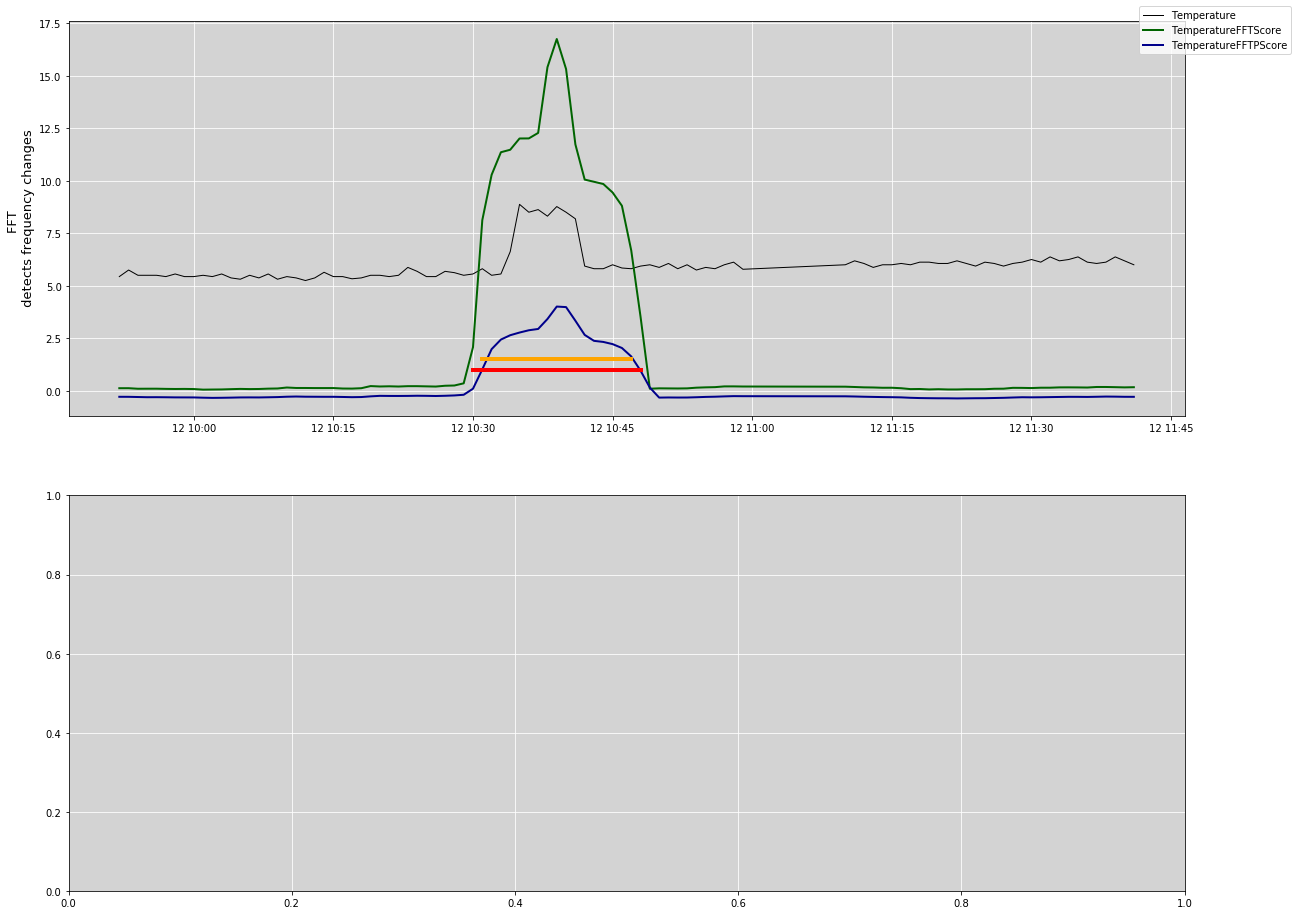

In [175]:
# df_inputm2[spectral].values[df_inputm2[spectral] > 0.001] = 0.001
# df_inputm2[fft].values[df_inputm2[fft] < -1] = -1
df_inputm2[kmeansA] = df_inputm2[kmeans]
df_inputm2[kmeansA].values[df_inputm2[kmeansA] < kmeans_break] = np.nan
df_inputm2[kmeansA].values[df_inputm2[kmeansA] > kmeans_break] = kmeans_break
df_inputm2[kmeansB] = df_inputm2[kmeans]
df_inputm2[kmeansB].values[df_inputm2[kmeansB] >= kmeans_break] = 4
df_inputm2[kmeansB].values[df_inputm2[kmeansB] < kmeans_break] = 3


df_inputm2[fftA] = df_inputm2[fft]
df_inputm2[fftA].values[df_inputm2[fftA] < fft_break] = np.nan
df_inputm2[fftA].values[df_inputm2[fftA] > fft_break] = fft_break
df_inputm2[fftpA] = df_inputm2[fftp]
#df_inputm2[fftp].values[df_inputm2[fft] > fftp_break] = fftp_break
df_inputm2[fftpA].values[df_inputm2[fftpA] < fftp_break] = np.nan
df_inputm2[fftpA].values[df_inputm2[fftpA] > fftp_break] = fftp_break
df_inputm2[spectralA] = df_inputm2[spectral]
df_inputm2[spectralA].values[df_inputm2[spectralA] < spectral_break] = np.nan
df_inputm2[spectralA].values[df_inputm2[spectralA] > spectral_break] = spectral_break
df_inputm2[salA] = df_inputm2[sal]
df_inputm2[salA].values[df_inputm2[salA] < sal_break] = np.nan
df_inputm2[salA].values[df_inputm2[salA] > sal_break] = sal_break
#df_inputm2[genA] = df_inputm2[gen]
#df_inputm2[genA].values[df_inputm2[genA] < gen_break] = np.nan
#df_inputm2[genA].values[df_inputm2[genA] > gen_break] = gen_break

plots = 2
x1=0
x2=4000
x1=3350
x2=3450
#x1 = 3550, x2 = 3650

fig, ax = plt.subplots(plots, 1, figsize=(20, 8 * plots))
cnt = 0
#ax[cnt].plot(df_inputm2.index[x1:x2], df_inputm2[Temperature][x1:x2]-20,linewidth=1,color='black',label=Temperature)
#ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
#ax[cnt].set_ylabel('Input Temperature - 20',fontsize=14,weight="bold")
cnt = 0
ax[cnt].plot(df_inputm2.index[x1:x2], df_inputm2[Temperature][x1:x2]-20,linewidth=1,color='black',label=Temperature)
ax[cnt].plot(df_inputm2.index[x1:x2], df_inputm2[fft][x1:x2]/fft_break, linewidth=2,color='darkgreen',label=fft)
ax[cnt].plot(df_inputm2.index[x1:x2], df_inputm2[fftp][x1:x2]/fftp_break, linewidth=2,color='darkblue',label=fftp)
ax[cnt].plot(df_inputm2.index[x1:x2], df_inputm2[fftA][x1:x2]/fft_break, linewidth=4, color='red', zorder=2)
ax[cnt].plot(df_inputm2.index[x1:x2], df_inputm2[fftpA][x1:x2]/fftp_break + 0.5, linewidth=4, color='orange', zorder=2)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('FFT \n detects frequency changes', fontsize=13)

for i in range(plots):
    ax[i].grid(True, color='white')
    ax[i].set_facecolor('lightgrey')

#### Results

Clear **winners** are 
* **KMeans** and 
* **FFT**.

Spectral is way too sensitive while Saliency 
doesn't detect the negative peak at 10/10 midnight
